# Google Natural Questions

**Projet final pour le CES Data Scientist**

Elève: Joël Aytunç ÜN

## Introduction

Le but de ce challenge est de créer un modèle d'apprentissage statistique pour répondre aux questions posées en se servant d'un corps de texte (i.e. Wikipedia). Pour accéder au lien du *challenge*, veuillez cliquez [ici](https://ai.google.com/research/NaturalQuestions).

## Présentation des données

Dans cette partie nous présentons les données fournies. Le format des données d'apprentissage est `json`. En revanche Google a créé une version tabulée des données qui se trouve dans ce [lien](https://ai.google.com/research/NaturalQuestions/databrowser).

Pour visualiser une observation de la base simplifiée, veuillez cliquez [ici](https://raw.githubusercontent.com/joelun37/Question-Answering/master/Documents/simplified-nq-train-for-content.json).

Vous pouvez également visualiser une observation de la base initiale, en cliquant [ici] ()

Nous utiliserons les données simplifiées par Google:

- **simplified-nq-train.jsonl**: 17.45 Go
- **simplified-nq-test.jsonl**: 18.8 Mo

La base d'apprentissage étant assez volumineuse, nous utiliserons le Google Cloud Platform pour nos calculs.

Ci-dessous, les nombres d'observations dans les bases fournies par Google:

- **Base d'apprentissage:** 307 373 observations
- **Base de validation (ou de développement):** 7 830 observations
- **Base de test:** 7 842 observations

In [4]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
from pyspark import SparkConf
from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark.sql.types import *
import time

local = "local[*]"
appName = "QA"
configLocale = SparkConf().setAppName(appName).setMaster(local).\
set("spark.executor.memory", "6G").\
set("spark.driver.memory", "6G").\
set("spark.sql.catalogImplementation", "in-memory")

spark = SparkSession.builder.config(conf = configLocale).getOrCreate()
sc = spark.sparkContext
sc.setLogLevel("ERROR")
spark


Afin d'inspecter le format du fichier `json`nous avons créé une version courte, que nous chargeons ici.

In [20]:
for_content = spark.read.json("/Volumes/750GB-HDD/root/Question-Answering/pyData/tensorflow2-question-answering/simplified-nq-train-for-content.json")

In [18]:
for_content.printSchema()

root
 |-- annotations: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- annotation_id: long (nullable = true)
 |    |    |-- long_answer: struct (nullable = true)
 |    |    |    |-- candidate_index: long (nullable = true)
 |    |    |    |-- end_token: long (nullable = true)
 |    |    |    |-- start_token: long (nullable = true)
 |    |    |-- short_answers: array (nullable = true)
 |    |    |    |-- element: struct (containsNull = true)
 |    |    |    |    |-- end_token: long (nullable = true)
 |    |    |    |    |-- start_token: long (nullable = true)
 |    |    |-- yes_no_answer: string (nullable = true)
 |-- document_text: string (nullable = true)
 |-- document_url: string (nullable = true)
 |-- example_id: long (nullable = true)
 |-- long_answer_candidates: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- end_token: long (nullable = true)
 |    |    |-- start_token: long (nullable = true)
 |    |    |

## Les variables

### Annotations

Cette variable contient réponses **longues** et **courtes**, s'il existe des réponses. Ci-dessous les règles de cette variable:

- Chaque question a une réponse longue au maximum. En revanche, il peut y avoir plusieurs réponses courtes.
- Les réponses courtes sont nécessairement contenues dans la réponse longue. Si la réponse est de type **Oui/Non**, alors `yes_no_answer` prend les valeurs `Yes` ou `No`. Par défaut, la valeur de cette variable est `None`.
- Seulement 1% des réponses sont de type **Oui/Non**.

### Document text
Cette variable contient le corps de la page Wikipedia en format *html*.

### Document URL
Cette variable contient le lien URL vers la page Wikipedia.

### Example ID
C'est l'identifiant de l'exemple.

### Long answer candidates
Cette variable contient les réponses candidates. 

- Parfois, une longue réponse est imbriquée dans une autre.
- Pour différencier ces deux types de réponses, on utilise la notion de **niveau**. Une réponse est donc contenue dans une autre si son indicateur *top level* est `False`.
- 95% des réponses longues sont du *top level* `True`. Nous pourrions donc, dans un premier temps, nous focaliser sur ces réponses uniquement.

### Question text
Il s'agit de la question posée au texte.

In [29]:
for_content.annotations

Column<b'annotations'>

In [22]:
for_content_2 = spark.read.json("/Volumes/750GB-HDD/root/Question-Answering/pyData/tensorflow2-question-answering/v1.0-simplified_nq-dev-all-for-content.json")

In [24]:
for_content_2.printSchema()

root
 |-- annotations: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- annotation_id: decimal(20,0) (nullable = true)
 |    |    |-- long_answer: struct (nullable = true)
 |    |    |    |-- candidate_index: long (nullable = true)
 |    |    |    |-- end_byte: long (nullable = true)
 |    |    |    |-- end_token: long (nullable = true)
 |    |    |    |-- start_byte: long (nullable = true)
 |    |    |    |-- start_token: long (nullable = true)
 |    |    |-- short_answers: array (nullable = true)
 |    |    |    |-- element: struct (containsNull = true)
 |    |    |    |    |-- end_byte: long (nullable = true)
 |    |    |    |    |-- end_token: long (nullable = true)
 |    |    |    |    |-- start_byte: long (nullable = true)
 |    |    |    |    |-- start_token: long (nullable = true)
 |    |    |-- yes_no_answer: string (nullable = true)
 |-- document_html: string (nullable = true)
 |-- document_title: string (nullable = true)
 |-- document_to

### BERT

BERT est un modèle de langage par Google.

#### Wordpieces: Le vocabulaire de BERT

Explique un peu. Inspect BERT vocabulary ipynb.

BERT a ete entraine sur Toronto Book Corpus et Wikipedia.

Le vocabulaire de BERT contient 30,522 mots. Pour résoudre le problème des mots n'existant pas dans son vocabulaire, BERT crée des "sous-mots". Vous pouvez consulter le vocabulaire, en cliquant [ici](https://raw.githubusercontent.com/joelun37/Question-Answering/master/pyNotebook/vocabulary.txt).

#### Nombre de paramètres de BERT

- **Embedding layer:** 30 522 token de dimension 768, donc environ 24M de poids au total
- **Transformers:** 12 transfomers, chacun ayant 7M poids donc environ 85M de poids

Au total, le modèle prend environ 440 Mo d'espace.

In [42]:
with open("vocabulary.txt", 'w') as f:
    
    # For each token...
    for token in tokenizer.vocab.keys():
        
        # Write it out and escape any unicode characters.            
        f.write(token + '\n')

In [47]:
!wc -l vocabulary.txt

   30522 vocabulary.txt


In [46]:
!head -10 vocabulary.txt

[PAD]
[unused0]
[unused1]
[unused2]
[unused3]
[unused4]
[unused5]
[unused6]
[unused7]
[unused8]


In [49]:
!gshuf -n 10 vocabulary.txt

contributions
wcw
landscapes
≈
circle
disposal
chance
elle
1730
##gui


### Première tentative de modélisation avec BERT

Nous avons réalisé une première tentative de modélisation en utilisant `Huggingface`. Cet exemple n'a pas trouvé la bonne réponse. Il faudra améliorer le modèle. Notre objectif serait d'implémenter la méthode expliquée [ici](https://web.stanford.edu/class/archive/cs/cs224n/cs224n.1194/reports/custom/15791880.pdf) car il s'agit du même challenge.

In [36]:
# Libraries
import re
from transformers import AutoTokenizer, AutoModelForQuestionAnswering
import torch
import json

# Mock test
# We are going to get 2 long answer candidates with the real long answer
# and feed it to the BERT model

example_txt = "/Volumes/750GB-HDD/root/Question-Answering/pyData/tensorflow2-question-answering/simplified-nq-train-for-content.json"
dev_example = "/Volumes/750GB-HDD/root/Question-Answering/pyData/tensorflow2-question-answering/v1.0-simplified_nq-dev-all-for-content.json"

def raw_NQ_data_dict(input_text_file):

    with open(input_text_file, 'r') as f:
        for line in f:
            example_dict = json.loads(line) 
            simplfied_ex =   (example_dict)

    return simplfied_ex

test_dict = raw_NQ_data_dict(input_text_file=example_txt)

long_answer_candidates = test_dict["long_answer_candidates"]
document_text = test_dict["document_text"]
question_text = test_dict["question_text"]

# [{'yes_no_answer': 'NONE',
#   'long_answer': {'start_token': 1952,
#    'candidate_index': 54,
#    'end_token': 2019},
#   'short_answers': [{'start_token': 1960, 'end_token': 1969}],
#   'annotation_id': 593165450220027640}]
annotations = test_dict["annotations"]

long_answer = ""
candidate_index = annotations[0]["long_answer"]["candidate_index"]

for i in range(long_answer_candidates[candidate_index]["start_token"], \
               long_answer_candidates[candidate_index]["end_token"]):
    long_answer += document_text.split()[i] + " "

short_answer = ""
for i in range(annotations[0]["short_answers"][0]["start_token"], \
               annotations[0]["short_answers"][0]["end_token"]):
    short_answer += document_text.split()[i] + " "

# First two candidates
candidate_dict = {}

i = 0
while len(candidate_dict.keys()) < 2:
    if long_answer_candidates[i]["top_level"] == True:
        txt = ""
        for j in range(long_answer_candidates[i]["start_token"], \
                       long_answer_candidates[i]["end_token"]):
            txt += document_text.split()[j] + " "
        candidate_dict[i] = txt
    i += 1

def remove_html_tags(text):
    """Remove html tags from a string"""
    clean = re.compile('<.*?>')
    return re.sub(clean, '', text)

tokenizer = AutoTokenizer.from_pretrained("bert-large-uncased-whole-word-masking-finetuned-squad")
model = AutoModelForQuestionAnswering.from_pretrained("bert-large-uncased-whole-word-masking-finetuned-squad")

text = ""
for key in candidate_dict.keys():
    text += candidate_dict[key]

text += text + long_answer    
    
inputs = tokenizer.encode_plus(question_text, remove_html_tags(text), add_special_tokens=True, return_tensors="pt")
input_ids = inputs["input_ids"].tolist()[0]
text_tokens = tokenizer.convert_ids_to_tokens(input_ids)
answer_start_scores, answer_end_scores = model(**inputs)
answer_start = torch.argmax(
    answer_start_scores
)  # Get the most likely beginning of answer with the argmax of the score
answer_end = torch.argmax(answer_end_scores) + 1  # Get the most likely end of answer with the argmax of the score
answer = tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(input_ids[answer_start:answer_end]))

print(f"Question: {question_text}\n")
print(f"Answer found by the model: {answer}\n")
print(f"Long Answer: {remove_html_tags(long_answer)}\n")
print(f"Short Answer: {short_answer}")

Question: which is the most common use of opt-in e-mail marketing

Answer found by the model: [CLS]

Long Answer:  A common example of permission marketing is a newsletter sent to an advertising firm 's customers . Such newsletters inform customers of upcoming events or promotions , or new products . In this type of advertising , a company that wants to send a newsletter to their customers may ask them at the point of purchase if they would like to receive the newsletter .  

Short Answer: a newsletter sent to an advertising firm 's customers 


### Deuxieme tentative avec BERT

In [1]:
# Libraries
import autoreload
%load_ext autoreload

import re
import json 
import torch
import numpy as np
import matplotlib.pyplot as plt 
from transformers import BertTokenizer
from transformers import BertModel

from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [2]:
# Set parameters and paths
pyData = "/Volumes/750GB-HDD/root/Question-Answering/pyData/"
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

In [3]:
# Import data
nq_train_txt_short = pyData + "tensorflow2-question-answering/simplified-nq-train-short.json"

In [ ]:
def remove_html_tags(text):
    """Remove html tags from a string"""
    clean = re.compile('<.*?>')
    return re.sub(clean, '', text)

In [11]:
def reduce_to_k_dim(M, k=2):
        
        n_iters = 10
        M_reduced = None
        print(f"Running Truncated SVD over {M.shape[0]} records...")

        svd = TruncatedSVD(n_components=k, n_iter=n_iters, random_state=42)
        svd.fit_transform(M)
        print(f"Explained variance ratios: {svd.explained_variance_ratio_}")
        M_reduced = svd.fit_transform(M)
        print("Done.")

        return M_reduced

def reduce_to_k_dim_PCA(M, k=2, title=None, path=None, file_name=None, kernel=None, plot_graph=True):
        
        M_reduced = None
        print(f"Running PCA over {M.shape[0]} records...")
        
        if kernel is not None:
                rbf_pca = KernelPCA(n_components=k,
                                    kernel="rbf",
                                    gamma=0.04,
                                    )
                
                M_reduced = rbf_pca.fit_transform(M)
                cumsum = np.cumsum(rbf_pca.explained_variance_ratio_)
        else:
                pca = PCA(n_components=k, random_state=42)
                M_reduced = pca.fit_transform(M)
                cumsum = np.cumsum(pca.explained_variance_ratio_)

#         print(f"Cumsum:{cumsum}")
        d55 = np.argmax(cumsum >= 0.55) + 1
        d70 = np.argmax(cumsum >= 0.70) + 1
        d85 = np.argmax(cumsum >= 0.85) + 1
        d90 = np.argmax(cumsum >= 0.90) + 1
        print(f"Initial number of dimensions:{M.shape[1]}")
        print(f"Number of principal components explaining 55% of the variance: {d55}")
        print(f"Number of principal components explaining 70% of the variance: {d70}")
        print(f"Number of principal components explaining 85% of the variance: {d85}")
        print(f"Number of principal components explaining 90% of the variance: {d90}")
#         print(f"Explained variance ratios: {pca.explained_variance_ratio_}")
        print("Done.")
        if plot_graph is not False:
                plt.figure(figsize=(8, 3.5))
                plt.plot(range(1, k+1), cumsum, "bo-")
                plt.xlabel("Dimensions", fontsize=14)
                plt.ylabel("Explained Variance Ratio", fontsize=14)
                # plt.annotate("Elbow",
                #         xy=(3, inertias[2]),
                #         xytext=(0.55, 0.55),
                #         textcoords="figure fraction",
                #         fontsize=16,
                #         arrowprops=dict(facecolor="black", shrink=0.1)
                #         )
                # plt.axis([1, (k + 0.5), 0, 1])
                plt.xticks(range(1, k+1))
                if title is not None:
                        plt.title(title)
                if (path is not None) and (file_name is not None):
                        plt.savefig(path + file_name)
                plt.show()

        return M_reduced


In [4]:
dict_obs = {}
dict_obs["question"] = []
dict_obs["long_answer"] = []
dict_obs["transformed_question"] = []
dict_obs["start_transformed_long_answer"] = []
dict_obs["end_transformed_long_answer"] = []

Tentative faisant l'hypothèse qu'une réponse avec plus de 512 mots est trop longue.

In [7]:
with open(nq_train_txt_short, 'r') as f:
    counter = 0
    for line in f:
        obs = json.loads(line)
        long_answer_candidate_index = obs["annotations"][0]["long_answer"]["candidate_index"]
        long_answer_candidate_index = obs["annotations"][0]["long_answer"]["candidate_index"]
        long_answer_start = obs["long_answer_candidates"][long_answer_candidate_index]["start_token"]
        long_answer_end = obs["long_answer_candidates"][long_answer_candidate_index]["end_token"]
        long_answer =""
        
        for i in range(long_answer_start, long_answer_end):
            long_answer += obs["document_text"].split()[i] + " "
        
        if len(remove_html_tags(long_answer)) <= 512:
            dict_obs["question"].append(obs["question_text"])
            dict_obs["long_answer"].append(remove_html_tags(long_answer))

            question_inputs = tokenizer.encode_plus(obs["question_text"], add_special_tokens=True, return_tensors="pt")
            question_input_ids = question_inputs["input_ids"].tolist()[0]
            question_text_tokens = tokenizer.convert_ids_to_tokens(question_input_ids)

            long_answer_inputs = tokenizer.encode_plus(remove_html_tags(long_answer), add_special_tokens=True, return_tensors="pt")
            long_answer_input_ids = long_answer_inputs["input_ids"].tolist()[0]
            long_answer_text_tokens = tokenizer.convert_ids_to_tokens(long_answer_input_ids)

            question_outputs = model(**question_inputs)
            long_answer_outputs = model(**long_answer_inputs)

           # Last hidden states
            question_last_hidden_states = question_outputs[0].detach().numpy().reshape(len(question_text_tokens), 768)
            long_answer_last_hidden_states = long_answer_outputs[0].detach().numpy().reshape(len(long_answer_text_tokens), 768)

           # Transformed
            transformed_question = question_last_hidden_states[0]
            start_transformed_long_answer = long_answer_last_hidden_states[0]
            end_transformed_long_answer = long_answer_last_hidden_states[len(long_answer_text_tokens) - 1]

            # Append transformed texts
            dict_obs["transformed_question"].append(transformed_question)
            dict_obs["start_transformed_long_answer"].append(start_transformed_long_answer)
            dict_obs["end_transformed_long_answer"].append(end_transformed_long_answer)

        # print(f"\n \n Question text: {obs['question_text']} \n  Length: {len(remove_html_tags(long_answer))} \n Long answer: {remove_html_tags(long_answer)} \n \n ")

        if len(remove_html_tags(long_answer)) <= 512:
            counter += 1

    print(f"The number of reasonably long answers is {counter}")

The number of reasonably long answers is 295


Running PCA over 295 records...
Initial number of dimensions:768
Number of principal components explaining 55% of the variance: 22
Number of principal components explaining 70% of the variance: 44
Number of principal components explaining 85% of the variance: 87
Number of principal components explaining 90% of the variance: 114
Done.


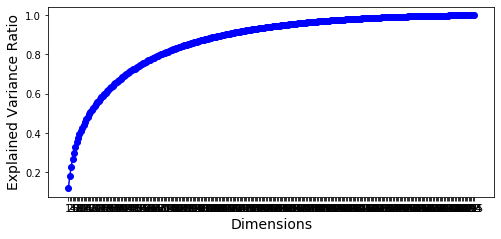

In [12]:
# Create X
X = dict_obs["transformed_question"][0].reshape(1, -1)
for q in range(1, len(dict_obs["transformed_question"])):
  X = np.vstack((X, dict_obs["transformed_question"][q].reshape(1, -1)))

# 44 axes explains 70%
reduced_X = reduce_to_k_dim_PCA(X, k=295)

Running PCA over 295 records...
Initial number of dimensions:768
Number of principal components explaining 55% of the variance: 19
Number of principal components explaining 70% of the variance: 41
Number of principal components explaining 85% of the variance: 87
Number of principal components explaining 90% of the variance: 115
Done.


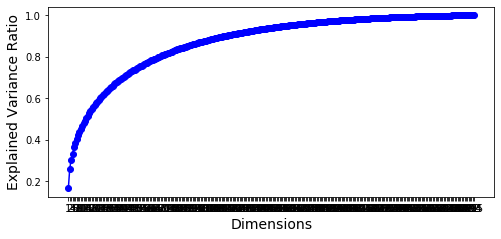

In [13]:
# Create y1
y1 = dict_obs["start_transformed_long_answer"][0].reshape(1, -1)
for q in range(1, len(dict_obs["start_transformed_long_answer"])):
  y1 = np.vstack((y1, dict_obs["start_transformed_long_answer"][q].reshape(1, -1)))

# 41 axes explain 70%
reduced_y1 = reduce_to_k_dim_PCA(y1, k=295)

Running PCA over 295 records...
Initial number of dimensions:768
Number of principal components explaining 55% of the variance: 4
Number of principal components explaining 70% of the variance: 16
Number of principal components explaining 85% of the variance: 50
Number of principal components explaining 90% of the variance: 73
Done.


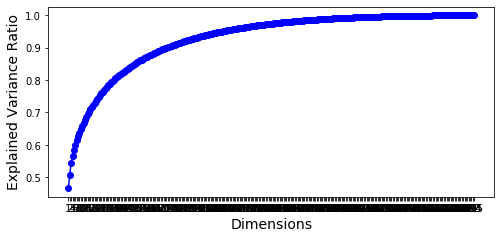

In [14]:
# Create y2
y2 = dict_obs["end_transformed_long_answer"][0].reshape(1, -1)
for q in range(1, len(dict_obs["end_transformed_long_answer"])):
  y2 = np.vstack((y2, dict_obs["end_transformed_long_answer"][q].reshape(1, -1)))

# 50 axes explain 85%
reduced_y2 = reduce_to_k_dim_PCA(y2, k=295)